In [ ]:
%pip install psycopg2

   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
   ------------------ --------------------- 0.5/1.2 MB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 1.2/1.2 MB 2.7 MB/s eta 0:00:00


In [2]:
import psycopg2
import pandas as pd

# Database connection
conn = psycopg2.connect(
    dbname="recommender",
    user="postgres",
    password="12345678",
    host="localhost",
    port="5432"
)

# Function to execute SQL and return DataFrame
def query_to_df(query):
    return pd.read_sql(query, conn)

In [3]:
# Queries
provision_query = "SELECT customer_id, service_id, prov_date, customer_name, customer_phone, bsk_id, bsk_name, docket_no FROM ml_provision;"
citizen_query = "SELECT citizen_id, citizen_name, citizen_phone, gender, dob, age, caste, religion, district_id, sub_div_id, gp_id FROM ml_citizen_master;"
service_query = "SELECT service_id, service_name, department_id, department_name, is_paid_service, service_type FROM ml_service_master;"

# Load into DataFrames
provision_df = query_to_df(provision_query)
citizen_df = query_to_df(citizen_query)
service_df = query_to_df(service_query)

C:\Users\AICOE\AppData\Local\Temp\ipykernel_1012\2247892287.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, conn)


In [4]:
print("Provision DataFrame:")
print(provision_df.head())
print(provision_df.info())
print("\nCitizen DataFrame:")
print(citizen_df.head())
print(citizen_df.info())
print("\nService DataFrame:")
print(service_df.head())
print(service_df.info())

Provision DataFrame:
    customer_id  service_id            prov_date        customer_name  \
0  GRPD_7087933         352  31/03/2025 20:39:54        Sayema khatun   
1  GRPF_9903885         357  31/03/2025 12:00:34        PRADIP MONDAL   
2  GRPB_9333501         392  31/01/2025 23:42:52        HEMONTA GHOSH   
3  GRPB_9630402         392  31/01/2025 23:42:23  SURJA NARAYAN MITRA   
4  GRPB_8842011         392  31/01/2025 23:42:03          SUMAN BAGDI   

  customer_phone  bsk_id                 bsk_name          docket_no  
0     9609645980     222  HARISCHANDRAPUR - I BDO  20250331203954856  
1     9932181232     882                 GAZNA GP  20250331120034784  
2     9475801203    1036              RAMNAGAR GP  20250131234252181  
3     8293588703    1036              RAMNAGAR GP  20250131234223670  
4     9001345678    1036              RAMNAGAR GP  20250131234203103  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5140830 entries, 0 to 5140829
Data columns (total 8 columns):
 #

In [5]:
print("Missing values in provision_df:")
print(provision_df.isnull().sum())
print("\nMissing values in citizen_df:")
print(citizen_df.isnull().sum())
print("\nMissing values in service_df:")
print(service_df.isnull().sum())

Missing values in provision_df:
customer_id       0
service_id        0
prov_date         0
customer_name     0
customer_phone    0
bsk_id            0
bsk_name          0
docket_no         0
dtype: int64

Missing values in citizen_df:
citizen_id         0
citizen_name       0
citizen_phone      0
gender           457
dob              457
age              457
caste            457
religion         455
district_id      457
sub_div_id       457
gp_id            457
dtype: int64

Missing values in service_df:
service_id          0
service_name        0
department_id      54
department_name     0
is_paid_service     0
service_type        0
dtype: int64


In [ ]:
# Drop rows with missing values in the relevant columns
columns_to_check = ['gender', 'age', 'caste', 'religion', 'district_id', 'sub_div_id', 'gp_id']
clean_citizen_df = citizen_df.dropna(subset=columns_to_check)

# Print the number of remaining rows
print("Remaining rows after dropping missing data:", len(clean_citizen_df))

Remaining rows after dropping missing data: 765310


In [7]:
unique_dept_ids = service_df['department_id'].nunique()
print(f"Number of unique department IDs: {unique_dept_ids}")

Number of unique department IDs: 40


In [8]:
service_df['department_id']=service_df['department_id'].fillna(-1)

In [9]:
unique_customer_ids = provision_df['customer_id'].nunique()
print(f"Number of unique customer IDs: {unique_customer_ids}")

unmatched_customers = provision_df[~provision_df['customer_id'].isin(citizen_df['citizen_id'])]
unmatched_services = provision_df[~provision_df['service_id'].isin(service_df['service_id'])]
print(f"Unmatched customer IDs: {len(unmatched_customers)}")
print(f"Unmatched service IDs: {len(unmatched_services)}")

Number of unique customer IDs: 2187370
Unmatched customer IDs: 3858591
Unmatched service IDs: 0


In [10]:
# Convert prov_date to datetime
provision_df['prov_date'] = pd.to_datetime(provision_df['prov_date'], format='%d-%m-%Y %H:%M', errors='coerce')

# Ensure numeric IDs are integers
citizen_df['age'] = citizen_df['age'].astype('Int64')  # Handles missing values
provision_df['service_id'] = provision_df['service_id'].astype(int)
service_df['department_id'] = service_df['department_id'].astype(int)

In [11]:
# Check data types
print("Data types in provision_df:")
print(provision_df.dtypes)
print("\nSample prov_date values:")
print(provision_df['prov_date'].head())

print("\nData types in citizen_df:")
print(citizen_df.dtypes)
print("\nSample age values:")
print(citizen_df['age'].head())

print("\nData types in service_df:")
print(service_df.dtypes)
print("\nSample department_id values:")
print(service_df['department_id'].head())

Data types in provision_df:
customer_id               object
service_id                 int64
prov_date         datetime64[ns]
customer_name             object
customer_phone            object
bsk_id                     int64
bsk_name                  object
docket_no                 object
dtype: object

Sample prov_date values:
0   NaT
1   NaT
2   NaT
3   NaT
4   NaT
Name: prov_date, dtype: datetime64[ns]

Data types in citizen_df:
citizen_id        object
citizen_name      object
citizen_phone     object
gender            object
dob               object
age                Int64
caste             object
religion          object
district_id      float64
sub_div_id       float64
gp_id            float64
dtype: object

Sample age values:
0    45
1    37
2    18
3    45
4    22
Name: age, dtype: Int64

Data types in service_df:
service_id          int64
service_name       object
department_id       int64
department_name    object
is_paid_service      bool
service_type       object
dtype:

In [22]:
%pip install matplotlib seaborn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------- -------------------------------- 1.6/8.1 MB 9.3 MB/s eta 0:00:01
   ------------------ --------------------- 3.7/8.1 MB 9.9 MB/s eta 0:00:01
   --------------------------- ------------ 5.5/8.1 MB 9.6 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 9.3 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ----------------------- ---------------- 1.3/2.2 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 6.7 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --------------- ------------------------ 1.0/2.7 MB 6.3 MB/s eta 0:00:01
   ----------------------------------- ---- 2.4/2.7 MB 5.8 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 5.5 MB/s eta 0:00:00

   -----------------------------

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()


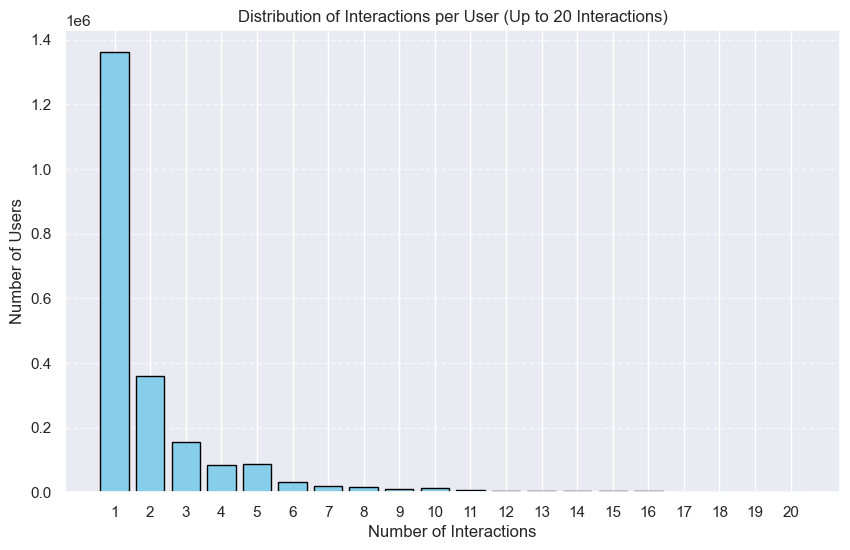

In [24]:
# 1. Provision Data: Interactions per User
interactions_per_user = provision_df.groupby('customer_id').size()

# Count how many users had each number of interactions
interaction_counts = interactions_per_user.value_counts().sort_index()

# Limit to interaction counts up to 22
interaction_counts = interaction_counts[interaction_counts.index <= 20]

plt.figure(figsize=(10, 6))
plt.bar(interaction_counts.index, interaction_counts.values, color='skyblue', edgecolor='black')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.title('Distribution of Interactions per User (Up to 20 Interactions)')
plt.xticks(interaction_counts.index)  # show all integer ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Missing service_name after merge: 0


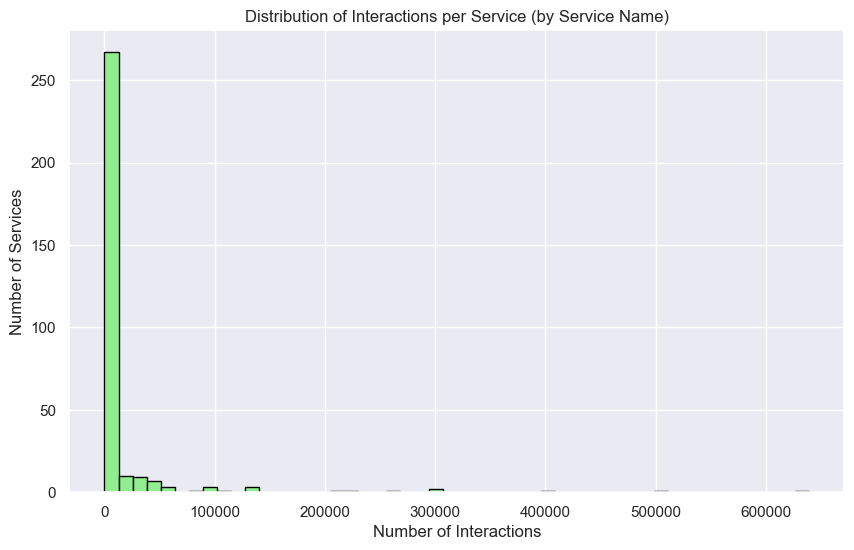

Number of unique services: 312


In [25]:
import matplotlib.pyplot as plt

# Merge provision_df with service_df to get service_name
merged_df = provision_df.merge(service_df[['service_id', 'service_name']], on='service_id', how='left')

# Check for missing service_name after merge
print("Missing service_name after merge:", merged_df['service_name'].isnull().sum())

# Group by service_name to count interactions
interactions_per_service = merged_df.groupby('service_name').size()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(interactions_per_service, bins=50, color='lightgreen', edgecolor='black')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Services')
plt.title('Distribution of Interactions per Service (by Service Name)')
plt.show()

# Print number of unique services
print(f"Number of unique services: {len(interactions_per_service)}")

In [ ]:
import pandas as pd

# Merge provision_df with service_df to get service_name
merged_df = provision_df.merge(service_df[['service_id', 'service_name']], on='service_id', how='left')

# Group by service_name to count interactions
interactions_per_service = merged_df.groupby('service_name').size().reset_index(name='interaction_count')

# Sort by interaction count in descending order
interactions_per_service = interactions_per_service.sort_values(by='interaction_count', ascending=False)

# Display the table
print(interactions_per_service)

# Save the table as a CSV for reference (optional)s
interactions_per_service.to_csv('interactions_per_service.csv', index=False)

                                          service_name  interaction_count
102        Apply - Payment of WBSEDCL Electricity Bill             639030
158  Apply - eKYC Seeding of Aadhaar with Digital R...             510891
9    Apply - Aadhaar & Mobile Link with Digital Rat...             396324
5                  Application for Income Certificates             301766
225  Search - Application Status of Digital Ration ...             298793
..                                                 ...                ...
209                    Register - Retail Liquor Outlet                 24
109            Apply - Provisional Admission for JEXPO                 20
32   Apply - Counselling of Choice Filling Up for J...                 16
0                     Apply - Renewal of Trade License                  6
86                          Apply - New Trade License                   3

[312 rows x 2 columns]


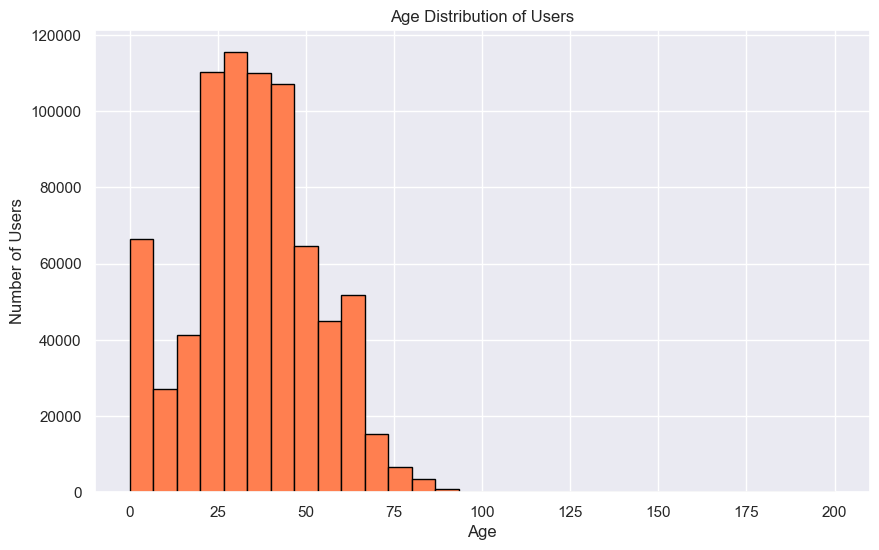

In [27]:
# 3. Citizen Data: Age Distribution
plt.figure(figsize=(10, 6))
citizen_df['age'].hist(bins=30, color='coral', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.title('Age Distribution of Users')
plt.show()

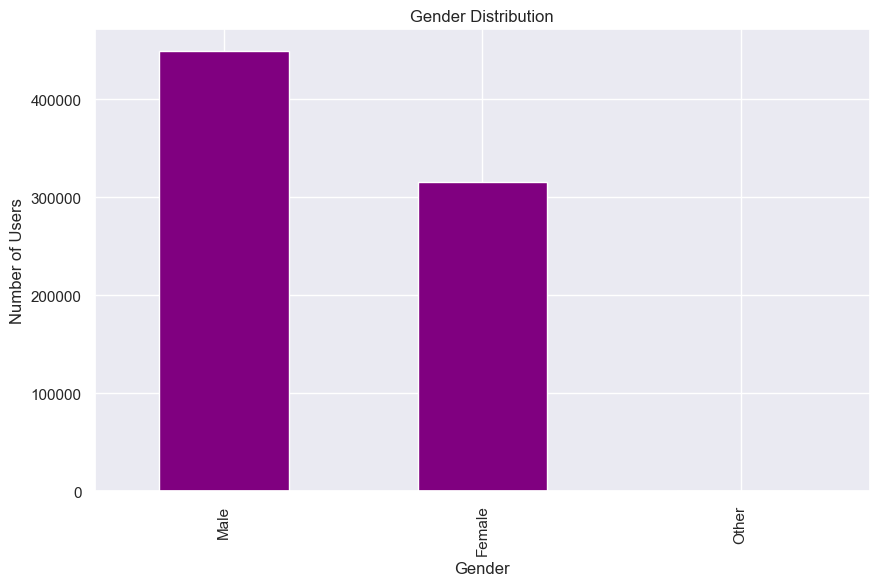

In [28]:
# 4. Citizen Data: Gender Distribution
plt.figure(figsize=(10, 6))
citizen_df['gender'].value_counts().plot(kind='bar', color='purple')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Gender Distribution')
plt.show()

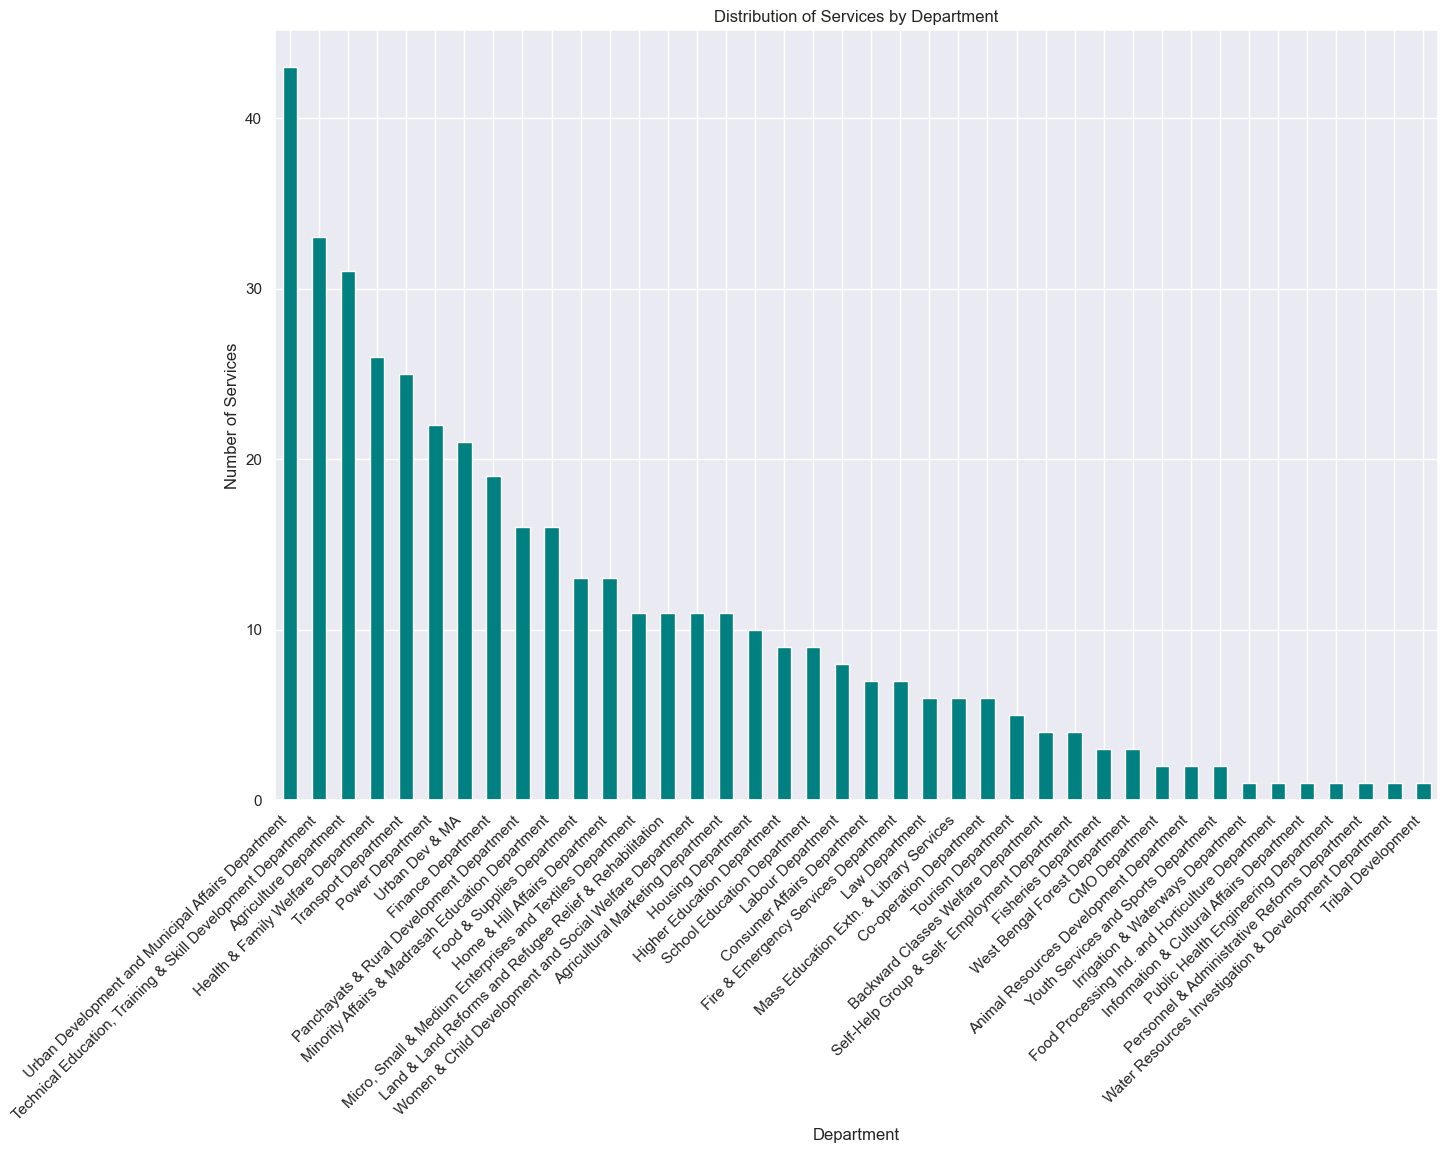

In [29]:
# 5. Service Data: Department Distribution
plt.figure(figsize=(15, 10))
service_df['department_name'].value_counts().plot(kind='bar', color='teal')
plt.xlabel('Department')
plt.ylabel('Number of Services')
plt.title('Distribution of Services by Department')
plt.xticks(rotation=45, ha='right')
plt.show()

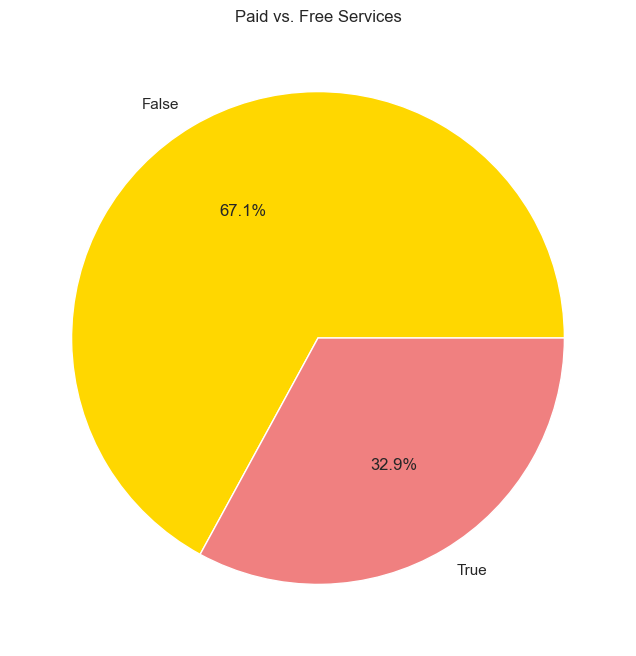

In [30]:
# 6. Service Data: Paid vs. Free Services
plt.figure(figsize=(8, 8))
service_df['is_paid_service'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['gold', 'lightcoral'])
plt.title('Paid vs. Free Services')
plt.ylabel('')
plt.show()

In [31]:
# Merge to associate each service usage with its department
usage_with_dept = provision_df.merge(service_df[['service_id', 'department_name']], on='service_id', how='left')


In [32]:
usage_per_department = usage_with_dept['department_name'].value_counts()


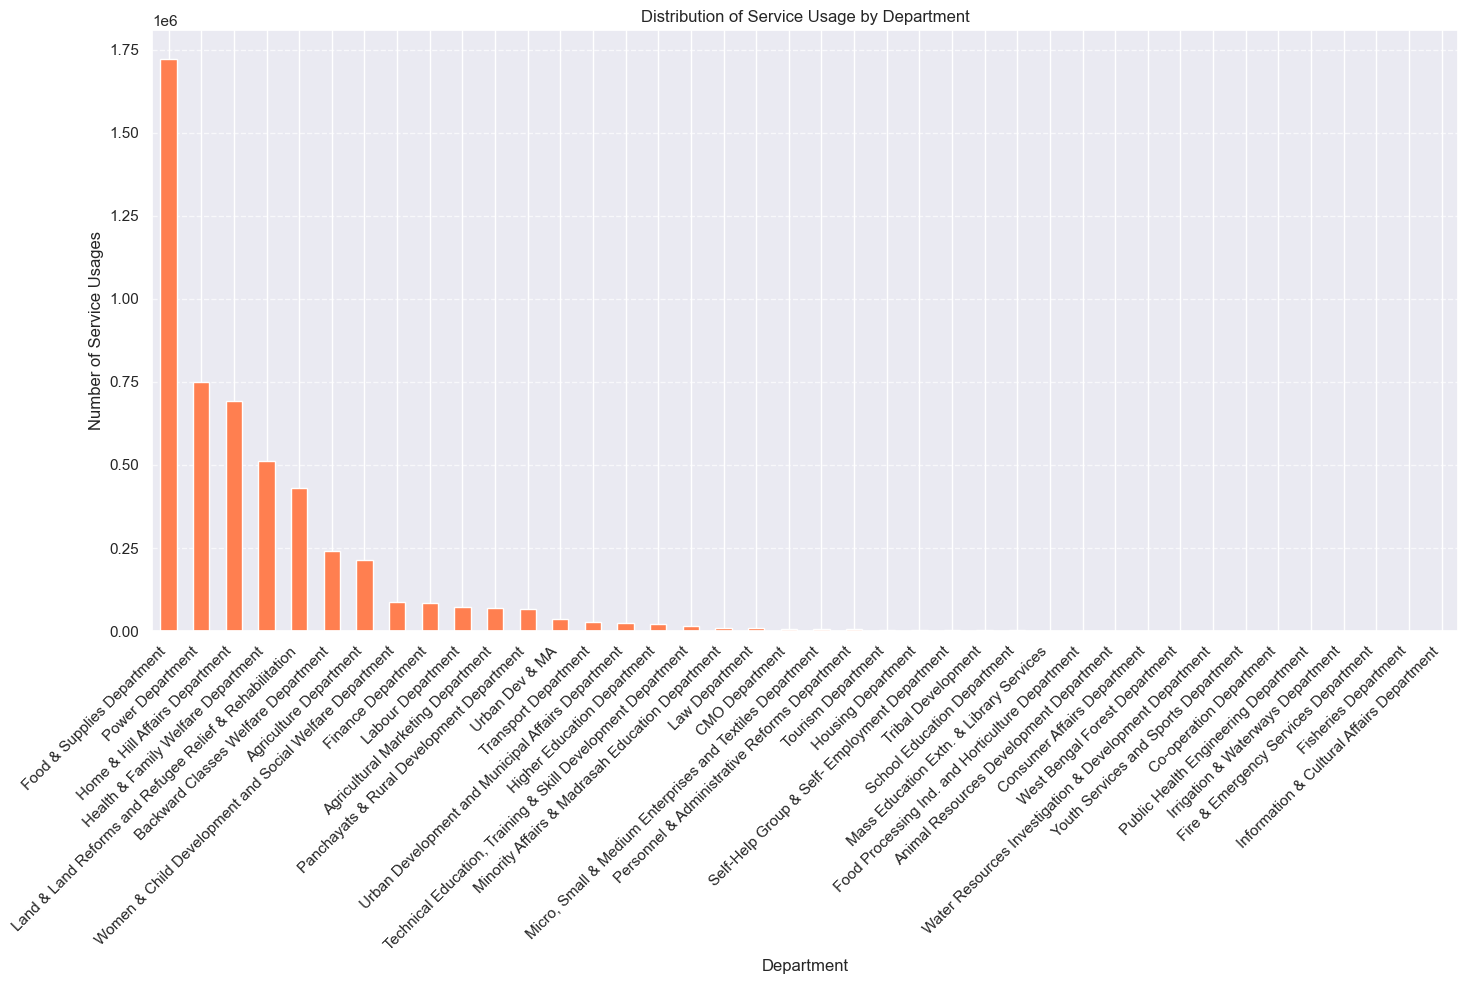

In [33]:
plt.figure(figsize=(15, 10))
usage_per_department.plot(kind='bar', color='coral')
plt.xlabel('Department')
plt.ylabel('Number of Service Usages')
plt.title('Distribution of Service Usage by Department')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
